# Implementing nonGaussian pdfs as Bayesian Priors

### Goal

In this notebook, I use the ICDF approximation methods to implement a Bayesian prior. 

The specfic use case is a BayeSN fit to photometry of SN 1997bq, where we marginalise over a prior on the photometric redshift (i.e. a 'photo-z pdf'). 

Firstly, I assume a Gaussian for this (redshift) prior, and implement a Gaussian distribution; and then, I implement the same distribution, but this time computed using the ICDF approximation, and show the results are the same.

### Stan code for photo-z prior

In [1]:
"""
functions {
	matrix spline_coeffs_irr(vector x, vector xk, matrix KD, real ext) { //i.e. the phase, time knots, KD matrix for cubic spline interpolation, and the maximum phase shift=5d
		int Nx = rows(x); //Nobs
		int Nk = rows(xk); //Ntknots
		matrix[Nx,Nk] X;

		if (max(x) > max(xk)+ext || min(x) < min(xk)-ext) { //If phase>40d + 5d OR phase<-10d -5d then stop
			reject("Spline interpolation error:", x);
		}

		X = rep_matrix(0,Nx,Nk); //Nphase points==Nobs by time knots==Ntknots

		for (n in 1:Nx) {
			real h;
			real a;
			real b;
			if (x[n] > xk[Nk]) { //if phase greater than 40d do linear extrapolation
				real f;

				h = xk[Nk] - xk[Nk-1]; //note in bayesn stan math notation, xk->x, and x->x*, this is den in eqn 19
				a = (xk[Nk] - x[n])/h; //first term in eqn 19
				b = 1 - a;
				f = (x[n] - xk[Nk])*h/6;

				X[n,Nk-1] = a;//these three are three terms in eqn 19
				X[n,Nk] = b;
				X[n,:] += f*KD[Nk-1,:];
			} else if (x[n] < xk[1]) { //elif phase less than -10d, also do linear extrapolation
				real f;

				h = xk[2] - xk[1];    //x2-x1 in last term of eqn 18
				b = (x[n] - xk[1])/h; //middle term in eqn 18, where x[n]==x*
				a = 1 - b;						//first term in eqn 18
				f = (x[n] - xk[1])*h/6; //last term in eqn 18

				X[n,1] = a; //index 1 because of e1T in eqn 18
				X[n,2] = b; //similarly, index2 because of e2T in eqn 18
				X[n,:] -= f*KD[2,:];//final term in eqn 18
			} else { //else do normal cubic interpolation
				int q;
				real c;
				real d;

				for (k in 1:Nk-1) {
					if (xk[Nk-k] <= x[n]) {
						q = Nk-k;
						break;
					}
				}

				h = xk[q+1] - xk[q];
				a = (xk[q+1] -x[n])/h;
				b = 1 - a;
				c = ((pow(a,3) - a)/6.0)*square(h);
				d = ((pow(b,3) - b)/6.0)*square(h);

				X[n,q] = a;
				X[n,q+1] = b;
				X[n,:] += c*KD[q,:] + d*KD[q+1,:];
			}
		}

		return X;
	}
	vector interpolate_hsiao(real t, vector th, matrix fh) {
		int Nh = rows(th);

		int q0;
		real t0;
		real t1;
		vector[cols(fh)] f0;
		vector[cols(fh)] f1;
		vector[cols(fh)] f;

		for (n in 1:Nh) {
			if (t < th[n]) {
				q0 = n-1;
				t0 = th[n-1];
				t1 = th[n];
				break;
			}
		}

		f0 = to_vector(fh[q0,:]);
		f1 = to_vector(fh[q0+1,:]);

		f = (f0*(t1-t) + f1*(t-t0))/(t1-t0);

		return f;
	}
	vector get_lrslice_indicator_from_z(vector hsiao_rest_tot,real pb_min,real pb_max,real z) {
		vector[rows(hsiao_rest_tot)] indicator;
		vector[rows(hsiao_rest_tot)] hsiao_obs;

		indicator = rep_vector(0,rows(hsiao_rest_tot));
		hsiao_obs = hsiao_rest_tot*(1+z);
		for (i in 1:rows(indicator)) {
			if (pb_min<hsiao_obs[i] && hsiao_obs[i]<pb_max) { //`logical and' notation is &&
				indicator[i] = 1;
			}
		}
		return indicator;
	}
	vector linearly_interpolate(vector xstar,vector X,vector Y) {
		vector[rows(xstar)] ystar;

		ystar = rep_vector(0,rows(xstar));

		for (istar in 1:rows(xstar)) {
			for (ix in 1:rows(X)) {
				if (X[ix] < xstar[istar] && xstar[istar]<X[ix+1]) {
					ystar[istar] = Y[ix] + ((Y[ix+1]-Y[ix])/(X[ix+1]-X[ix]))*(xstar[istar]-X[ix]);
				}
			}
		}
		return ystar;
	}
	real interpolate_monotonic_cubic(vector x,vector y,vector c1s,vector c2s,vector c3s,real xstar) {
    real ystar;

    if (xstar==x[rows(x)]) {
      ystar = y[rows(x)];
    }
    else {
      for (ix in 1:rows(x)-1) {
        real diff;
        diff = xstar-x[ix];
        if (x[ix]<xstar && xstar<x[ix+1]) {
          ystar = y[ix] + c1s[ix]*diff + c2s[ix]*(diff^2) + c3s[ix]*(diff^3);
          break;
        }
        else if (xstar==x[ix]) {
          ystar = y[ix];
          break;
        }
      }
		}
		return ystar;
  }
}
data {
	//Fitzpatrick99 knot wavelengths
	vector[9] xk;
	vector[9] yk_MW;
	real RV_MW;//MWay RV=3.1
	real EBV_MW;//MWay E(B-V)

	//Total number of observations
	int<lower=1> Nobs;
	//Total number of interpolation points
	int<lower=1> Dint;

	//Number of knots
	int<lower=1> Nknots;
	int<lower=1> Ntknots;
	int<lower=1> Nlknots;

	//Knot values
	vector[Ntknots] tk_unique;
	real tk[Nknots];
	real lk[Nknots];

	//Supernova data
	vector[Nobs] tobs;
	vector[Nobs] fobs;
	vector[Nobs] fobserr;


	//Photometric redshift
	//real zphot; //mean of Gaussian
	//real zphoterr;//std on Gaussian, eventually replace mean and std with a pdf
	real zphotmin;//chosen by some credible interval, min z used to choose passbands
	real zphotmax;//max z

	int Nzpdf; //number of ICDF points in z-pdf specified
  vector[Nzpdf] zicdf; //the ICDF z values, including zphotmin and zphotmax at 0 and 1
  vector<lower=0,upper=1>[Nzpdf] zquantiles; //the values on 0->1 for zphot pdf e.g. 0,0.05,0.16,0.5,0.84,0.95,1, should have 0 and 1 specified

  vector[Nzpdf] c1s;
  vector[Nzpdf-1] c2s;
  vector[Nzpdf-1] c3s;

  //Fixed guess for peak time
  real tmax_guess;
	//Permitted shift in phase of peak.
	real phase_shift;


	//CSR format precomputed matrices
	//Wavelength interpolation matrix
	int Jl_nnz;
	vector[Jl_nnz] Jl_w;
	int Jl_v[Jl_nnz];
	int Jl_u[Dint+1];
	////////////////////////////////////////////////////////////////////////////////////////////////
	//Passband integral
	int<lower=1>  Npb;   //Number of passbands
	int<lower=1>  pblen; //length of total lambda grid of passbands
	int<lower=1>  Bint;  //Number of interpolation points across all passbands

	//matrix[Dint,Bint] H1_matrix; //H1_matrix*Hvec gives one long vec that can be .* with Stilde
	int H1_nnz;
	vector[H1_nnz] H1_w;
	int H1_v[H1_nnz];
	int H1_u[Dint+1];

	//matrix[Nobs,Dint] H2_matrix; //H2_matrix*((H1_matrix*Hvec).*Stilde) is HS
	int H2_nnz;
	vector[H2_nnz] H2_w;
	int H2_v[H2_nnz];
	int H2_u[Nobs+1];

	int<lower=1>  H_lr_indices[Npb,2];
	vector[Bint] hsiao_rest_tot_long;
	real dLam; //Hsiao grid spacing==10A

	int<lower=1>  pb_lam_indices[Npb,2];
	vector[pblen] pb_lambdas; //the passband wavelength grid
	vector[pblen] pb_throughputs; //the passband throughput values

	matrix[Npb,2] pb_min_max_vector;//matrix that has min and max wavelengths for each filt
	vector[Nobs] column_map; //maps each observation to a filter

	matrix[9,9] KD_x;
	////////////////////////////////////////////////////////////////////////////////////////////////
	//Part of the spline matrix
	matrix[Ntknots,Ntknots] KDinv;

	//Stack of Hsiao template values to interpolate
	int Nhsiao;
	int nint[Nobs+1];
	vector[Nhsiao] thsiao;
	matrix[Nhsiao,Dint] fhsiao;

	//Dust law interpolation matrix
	matrix [Dint,9] M;

	//Distance prior params
	real muhat;
	real muhaterr;

	//SNANA zero_point
	real ZPT;

	//SED model parameters
	matrix[Nlknots,Ntknots] W0;
	matrix[Nlknots,Ntknots] W1;
	matrix[Nknots-2*Ntknots,Nknots-2*Ntknots] L_Sigma;
	real<lower=0> tauA;
	real M0;
	real<lower=0> sigma0;

	//Flag to toggle (truncated) normal RV prior
	int<lower=0, upper=1> RV_normal;
	//Flag for an infinite upper limit on RV
	int<lower=0, upper=1> RV_inf;
	//Limits on RV prior
	real RV_min;
	real RV_max[RV_inf ? 0 : 1];
	//Normal distribution parameters
	real<lower=RV_min, upper=(RV_inf ? positive_infinity() : RV_max[1])> muR[RV_normal ? 1 : 0];
	real<lower=0> sigmaR[RV_normal ? 1 : 0];
}
transformed data {
	//Convenient factor
	real gamma = log(10)/2.5;

	//Number of unpinned epsilons
	int Nfree;

	//Standard deviation of the del_M + mu sampling variable
	real Dserr;

	//Fitzpatrick 99 constants
	real f99_x0 = 4.596;
	real f99_gamma = 0.99;
	real f99_c3 = 3.23;
	real f99_c4 = 0.41;
	real f99_c5 = 5.9;
	vector[2] f99_d = square(xk[8:9]) ./ (square(square(xk[8:9]) - square(f99_x0)) + square(f99_gamma*xk[8:9]));

	Dserr = sqrt(square(muhaterr) + square(sigma0));

	Nfree = Nknots - 2*Ntknots;
}
parameters {
	real theta;
	real Ds;
	real<lower=0> AV;
	real <lower=RV_min, upper=(RV_inf ? positive_infinity() : RV_max[1])> RV;
	vector[Nfree] epsilon_tform; //Non-centred transform of epsilon matrix
	real<lower=0,upper=1> u_z;
}
transformed parameters {
	vector[Nfree] epsilon_free;
	matrix[Nlknots,Ntknots] epsilon;
	vector[Nobs] phase;
	real<lower=zphotmin,upper=zphotmax> zhel;


	epsilon_free = L_Sigma*epsilon_tform;
	epsilon = rep_matrix(0, Nlknots, Ntknots);
	epsilon[2:Nlknots-1, :] = to_matrix(epsilon_free, Nlknots-2, Ntknots);

	zhel  = interpolate_monotonic_cubic(zquantiles,zicdf,c1s,c2s,c3s,u_z); //input u~U(0,1) into ICDF, using monotonic cubic spline

	phase = (tobs - tmax_guess)/(1.0+zhel);
}
model {
	//Declare a variable for the latent fluxes/mags
	vector[Nobs] f;

	//Fitzpatrick99 parameters for host-galaxy
	real f99_c1;
	real f99_c2;
	vector[9] yk;

	//Hsiao template
	vector[Dint] S0;
	//Time interpolation matrix, although tmax fixed, phase changes
	matrix [Ntknots,Nobs] Jt;

	vector[Bint] Hvec; //vector of passbands that depends on z, e.g. all interpolation points at single phase
	vector[Dint] Hveclong; //vector of passbands with repeats due to same passband obs at different phases

	Jt = spline_coeffs_irr(phase, tk_unique, KDinv, phase_shift)';
	for (n in 1:Nobs) {
		S0[nint[n]:nint[n+1]-1] = interpolate_hsiao(phase[n], thsiao, fhsiao[:,nint[n]:nint[n+1]-1]); //recall S0 is Hsiao template
	}


	//Compute Fitzpatrick99 parameters
	f99_c2  = -0.824 + 4.717/RV;
	f99_c1  = 2.030 - 3.007*f99_c2;
	yk[1]   = -RV;
	yk[2]   =	0.26469*RV/3.1 - RV;
	yk[3]   = 0.82925*RV/3.1 - RV;
	yk[4]   = -0.422809 + 1.00270*RV + 2.13572e-4*square(RV) - RV;
	yk[5]   = -5.13540e-2 + 1.00216*RV - 7.35778e-5*square(RV) - RV;
	yk[6]   = 0.700127 + 1.00184*RV - 3.32598e-5*square(RV) - RV;
	yk[7]   = 1.19456 + 1.01707*RV - 5.46959e-3*square(RV) + 7.97809e-4*pow(RV,3) - 4.45636e-5*pow(RV,4) - RV;
	yk[8:9] = f99_c1 + f99_c2*xk[8:9] + f99_c3*f99_d;


	Hvec     = rep_vector(0,Bint);
	for (p in 1:Npb) {
		vector[H_lr_indices[p,2]-H_lr_indices[p,1]+1] hsiao_rest_tot;
		vector[H_lr_indices[p,2]-H_lr_indices[p,1]+1] one_over_hsiaoobstot;
		vector[H_lr_indices[p,2]-H_lr_indices[p,1]+1] indicator;
		vector[H_lr_indices[p,2]-H_lr_indices[p,1]+1] hsiao_obs_tot;
		vector[H_lr_indices[p,2]-H_lr_indices[p,1]+1] bthru;
		vector[H_lr_indices[p,2]-H_lr_indices[p,1]+1] Alam_MW;
		vector[H_lr_indices[p,2]-H_lr_indices[p,1]+1] f_lam_MW;

		hsiao_rest_tot        = hsiao_rest_tot_long[H_lr_indices[p,1]:H_lr_indices[p,2]];
		for (i in 1:rows(hsiao_rest_tot)){
			one_over_hsiaoobstot[i] = 1/(hsiao_rest_tot[i]*(1+zhel));
		}
		indicator      = get_lrslice_indicator_from_z(hsiao_rest_tot,pb_min_max_vector[p,1],pb_min_max_vector[p,2],zhel);
		hsiao_obs_tot  = indicator .* hsiao_rest_tot*(1+zhel);
		bthru          = linearly_interpolate(hsiao_obs_tot, pb_lambdas[pb_lam_indices[p,1]:pb_lam_indices[p,2]], pb_throughputs[pb_lam_indices[p,1]:pb_lam_indices[p,2]] );


		//M_MW   = spline_coeffs_irr(1e4/(hsiao_rest_tot*(1+z_dummy)), xk, KD_x)
		//Alam_MW= RV_MW*EBV_MW*(1.0 + spline_coeffs_irr(1e4/(hsiao_rest_tot*(1+zhel)), xk, KD_x)*yk_MW/ RV_MW);
		//f_lam_MW = 10^(-0.4*Alam_MW);
		Alam_MW  = RV_MW*EBV_MW*(1.0 + spline_coeffs_irr(1e4*one_over_hsiaoobstot, xk, KD_x, 0)*yk_MW/ RV_MW);
		for (i in 1:rows(Alam_MW)){
			f_lam_MW[i] = 10^(-0.4*Alam_MW[i]);
		}

		Hvec[H_lr_indices[p,1]:H_lr_indices[p,2]] = bthru .* hsiao_obs_tot .* f_lam_MW*dLam;
	}
	Hveclong = csr_matrix_times_vector(Dint, Bint, H1_w, H1_v, H1_u, Hvec); //This vector has zeros in appropriate places


	//Sampling statements for parameters
	u_z ~ uniform(0,1);
	theta ~ std_normal();
	Ds ~ normal(muhat, Dserr);
	AV ~ exponential(inv(tauA));
	if (RV_normal) {
		RV ~ normal(muR[1], sigmaR[1]);
	} else {
		RV ~ uniform(RV_min, RV_max[1]);
	}
	epsilon_tform ~ std_normal();

	//Calculate latent flux in a scope
	{
		vector[Nlknots*Nobs] WJt;
		vector[Dint] JlWJt;
		vector[Dint] Alam; //Host extinction at obs wavelengths
		vector[Dint] Stilde; //Host-extinguised SED
		vector[Nobs] HS;

		matrix[Nlknots,Ntknots] W; //Knots defining intrinsic SED

		//The sum of the intrinsic FCs and epsilon matrix
		W = W0 + theta*W1 + epsilon;

		//A matrix containing W*Jt in each column (reshaped into a vector)
		WJt = to_vector(W*Jt);

		//Interpolate intrinsic SED to obs times and wavelengths
		JlWJt = csr_matrix_times_vector(Dint, Nlknots*Nobs, Jl_w, Jl_v, Jl_u, WJt);
		Alam = AV*(1.0 + M*yk / RV);

		//Multiply by Hsiao template
		Stilde      = Hveclong .* S0 .* exp(-gamma*(JlWJt + Alam)); //This still has non-zero elements in it that don't count, but by multiplying by Hveclong, these elements go to zero


		//Integrate through passbands
		HS = csr_matrix_times_vector(Nobs, Dint, H2_w, H2_v, H2_u, Stilde);//The H1 matrix has encoded in it the zeros that kills any non-zero elements, H2 simply sums up the vector correctly
		//Correct for distance and mean abs magnitude
		f = exp(gamma*(ZPT - M0 - Ds)) * HS;
	}

	//Data likelihood
	fobs ~ normal(f, fobserr);
}
generated quantities {
	real delM;
	real mu;

	//Extract mu and del_M from their linear combination
	mu = normal_rng((Ds*square(muhaterr) + muhat*square(sigma0))/square(Dserr), sqrt((square(sigma0)*square(muhaterr))/square(Dserr)));
	delM = Ds - mu;
}
"""

'\nfunctions {\n\tmatrix spline_coeffs_irr(vector x, vector xk, matrix KD, real ext) { //i.e. the phase, time knots, KD matrix for cubic spline interpolation, and the maximum phase shift=5d\n\t\tint Nx = rows(x); //Nobs\n\t\tint Nk = rows(xk); //Ntknots\n\t\tmatrix[Nx,Nk] X;\n\n\t\tif (max(x) > max(xk)+ext || min(x) < min(xk)-ext) { //If phase>40d + 5d OR phase<-10d -5d then stop\n\t\t\treject("Spline interpolation error:", x);\n\t\t}\n\n\t\tX = rep_matrix(0,Nx,Nk); //Nphase points==Nobs by time knots==Ntknots\n\n\t\tfor (n in 1:Nx) {\n\t\t\treal h;\n\t\t\treal a;\n\t\t\treal b;\n\t\t\tif (x[n] > xk[Nk]) { //if phase greater than 40d do linear extrapolation\n\t\t\t\treal f;\n\n\t\t\t\th = xk[Nk] - xk[Nk-1]; //note in bayesn stan math notation, xk->x, and x->x*, this is den in eqn 19\n\t\t\t\ta = (xk[Nk] - x[n])/h; //first term in eqn 19\n\t\t\t\tb = 1 - a;\n\t\t\t\tf = (x[n] - xk[Nk])*h/6;\n\n\t\t\t\tX[n,Nk-1] = a;//these three are three terms in eqn 19\n\t\t\t\tX[n,Nk] = b;\n\t\t\t\tX

Firstly, we have the posterior from fitting the Gaussian from the Gaussian-family-function in Stan

The dashed line is the prior, and full KDE line is the posterior

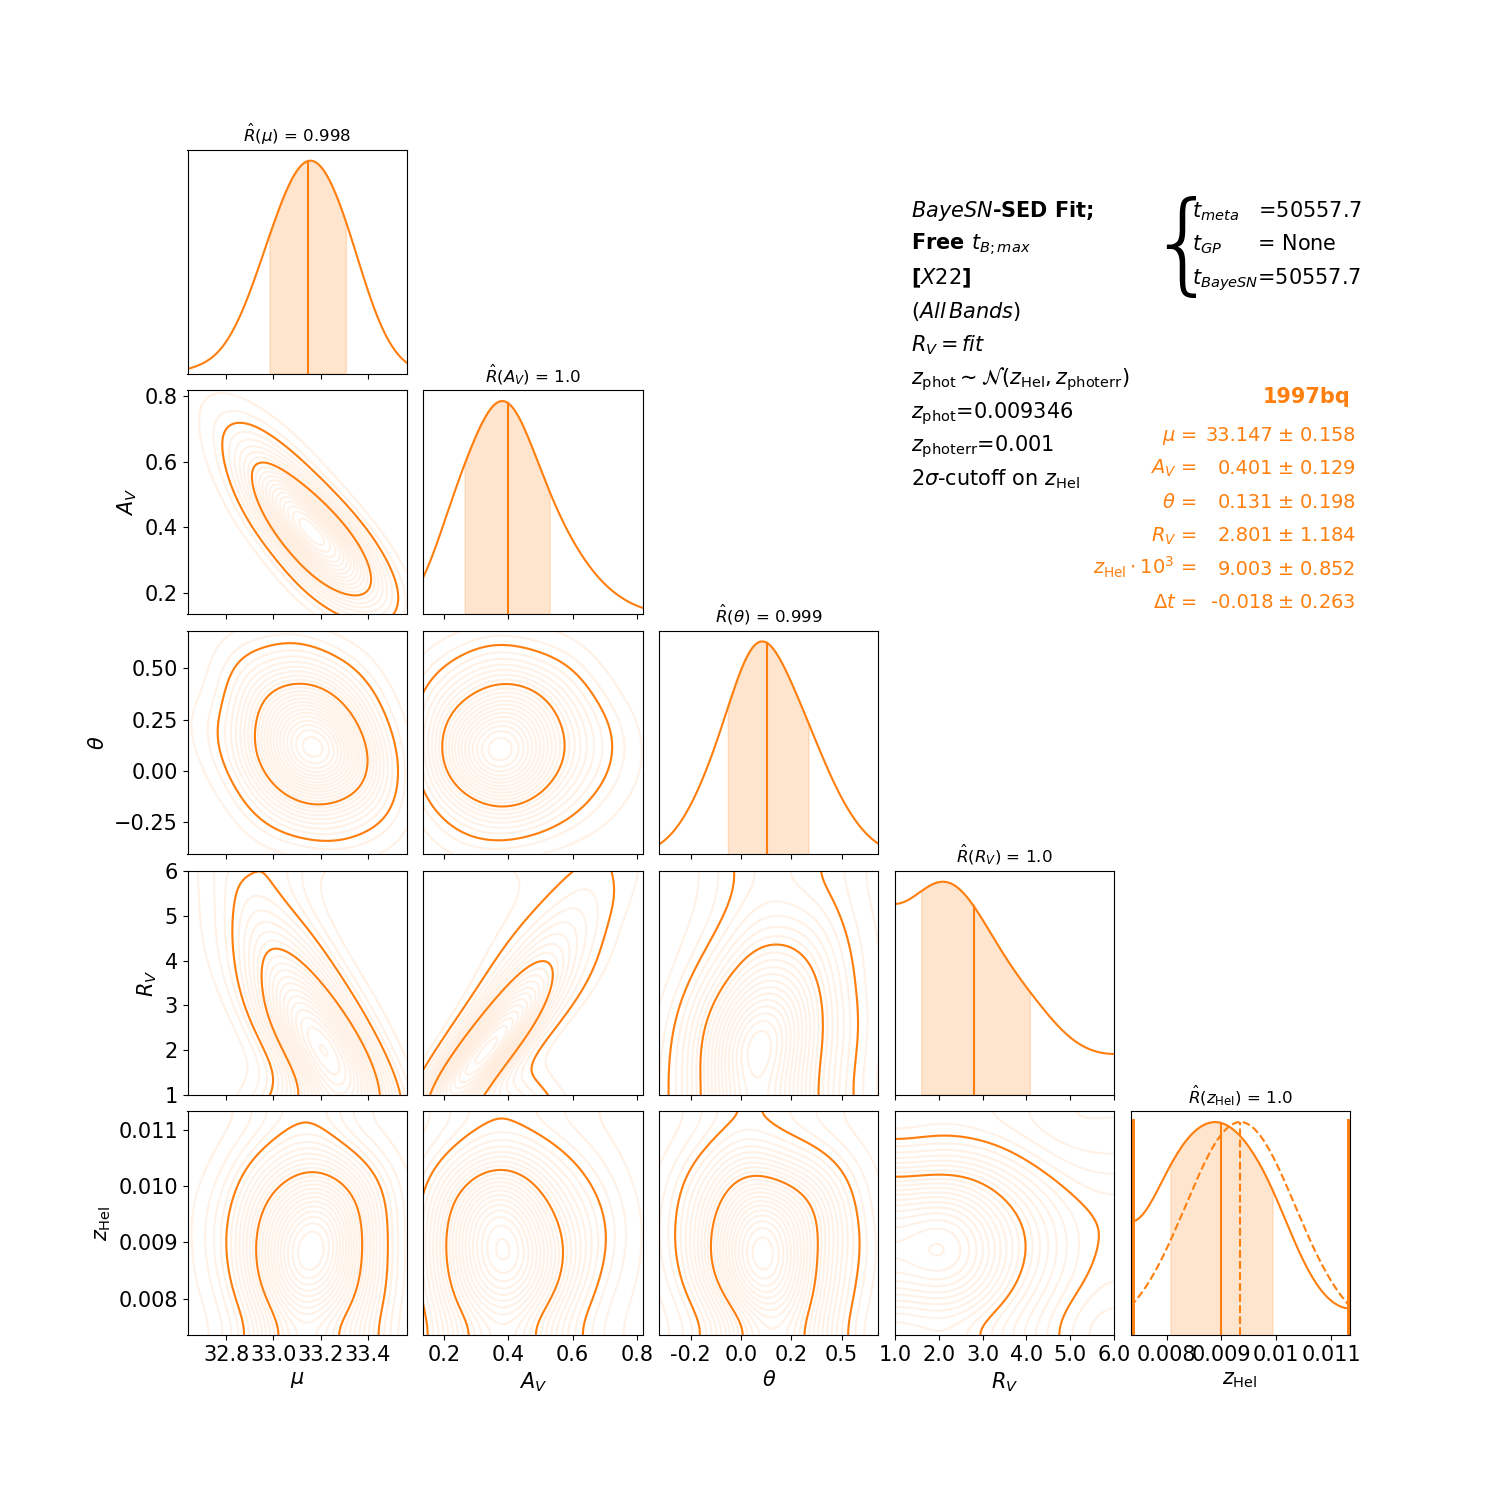

Next, we implement the same Bayesian prior, but 

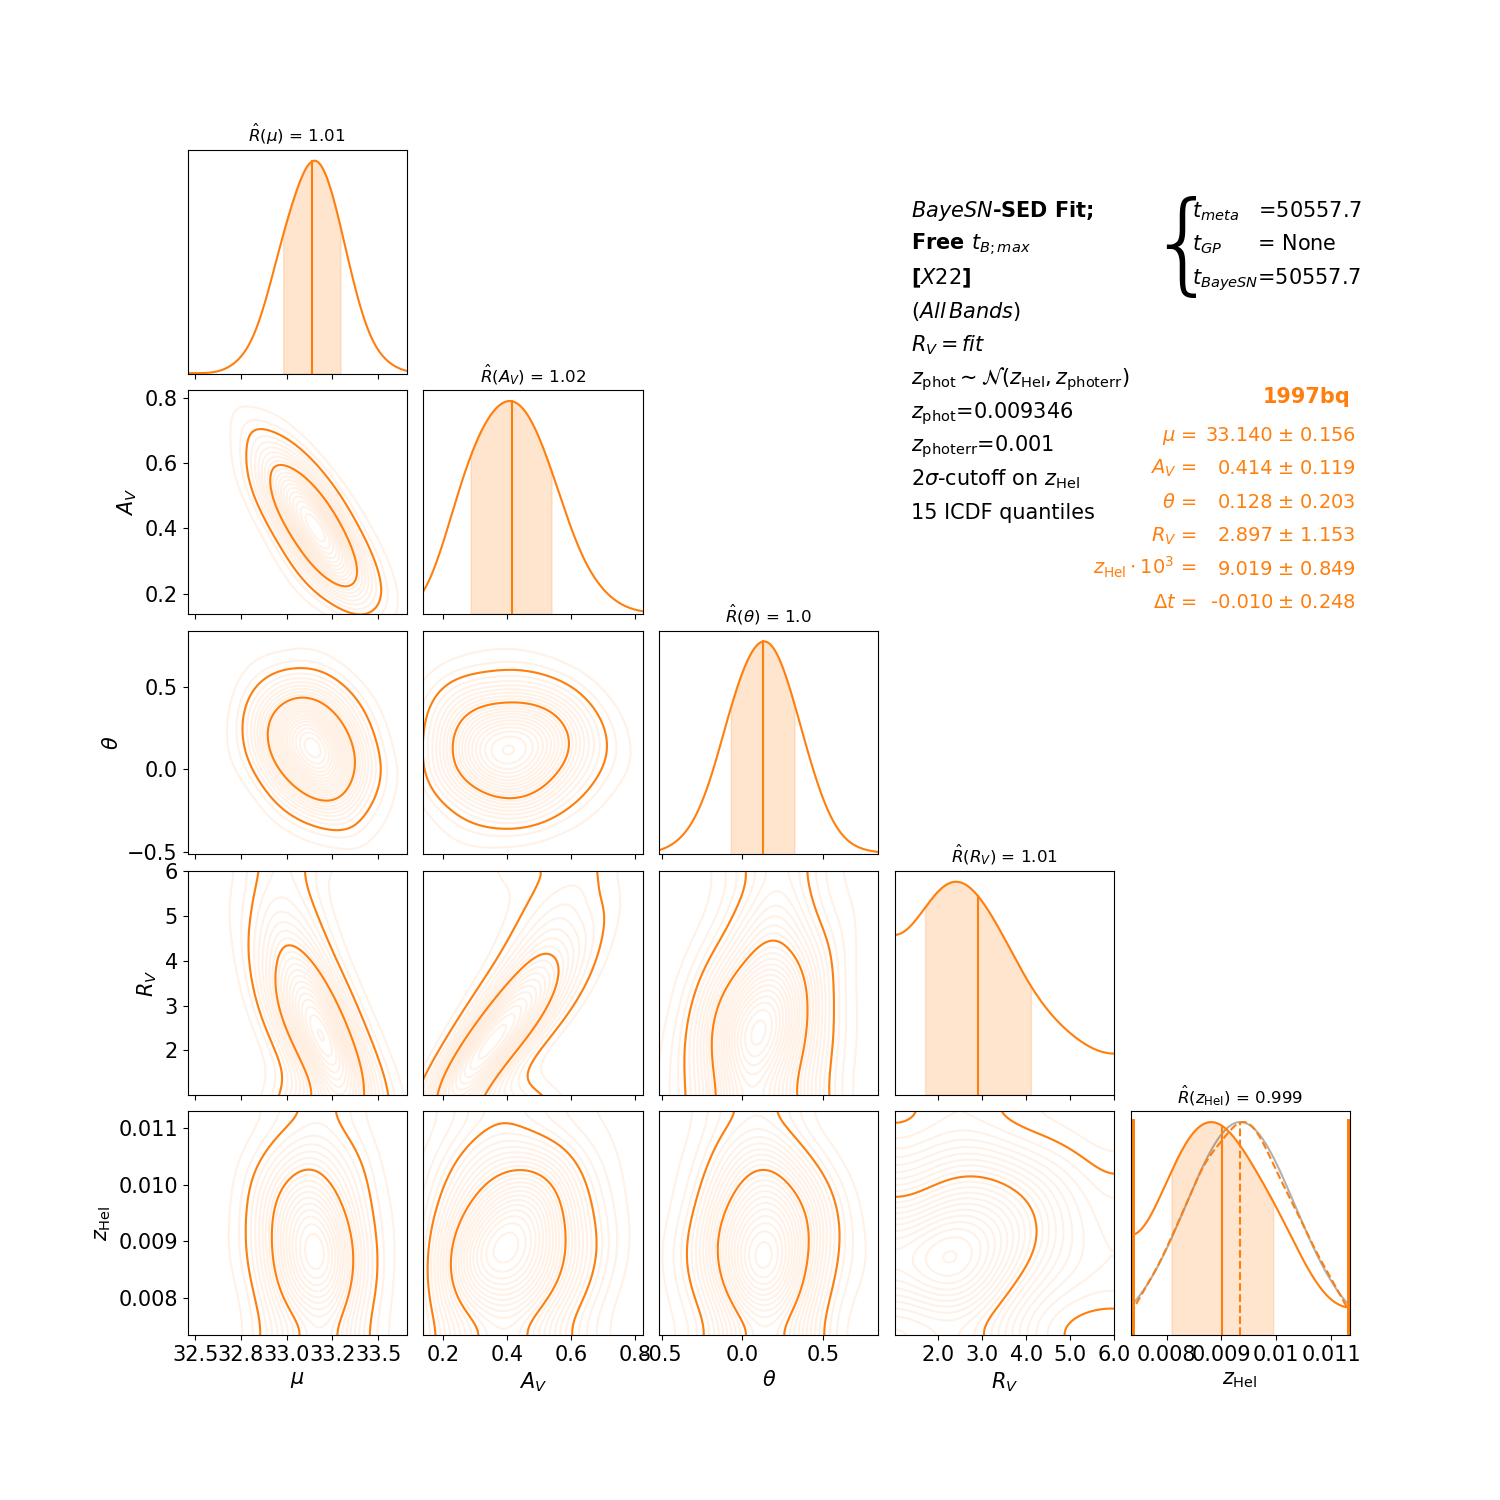